In [1]:
# Import data
import pandas as pd

papers = pd.read_csv('../data/compdata.csv', index_col=False)

In [8]:
import pickle
docs = pickle.load(open('docs.pkl','rb'))

In [11]:
import gensim
def pre_process(docs):
    for i in range(len(docs)):
        yield gensim.models.doc2vec.TaggedDocument(docs[i], [i])
        
train_corpus = list(pre_process(docs))
#test_corpus = list(read_corpus(lee_test_file, tokens_only=True))

In [3]:
import gensim

vector_size=50
min_count=2
epochs=40

model = gensim.models.doc2vec.Doc2Vec(vector_size=vector_size, min_count=min_count, epochs=epochs)

In [13]:
model.build_vocab(train_corpus)

In [15]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [16]:
print(docs[0])
print(model.infer_vector(docs[0]))

['ultra', 'low', 'dose', 'chest', 'ct', 'imaging', 'of', 'covid', 'patient', 'using', 'deep', 'residual', 'neural', 'network', 'objective', 'the', 'current', 'study', 'aimed', 'to', 'design', 'an', 'ultra', 'low', 'dose', 'ct', 'examination', 'protocol', 'using', 'deep', 'learning', 'approach', 'suitable', 'for', 'clinical', 'diagnosis', 'of', 'covid', 'patient', 'method', 'in', 'this', 'study', 'and', 'pair', 'of', 'ultra', 'low', 'dose', 'and', 'full', 'dose', 'ct', 'image', 'were', 'used', 'a', 'input', 'output', 'a', 'training', 'test', 'and', 'external', 'validation', 'set', 'respectively', 'to', 'implement', 'the', 'full', 'dose', 'prediction', 'technique', 'residual', 'convolutional', 'neural', 'network', 'wa', 'applied', 'to', 'generate', 'full', 'dose', 'from', 'ultra', 'low', 'dose', 'ct', 'image', 'the', 'quality', 'of', 'predicted', 'ct', 'image', 'wa', 'assessed', 'using', 'root', 'mean', 'square', 'error', 'rmse', 'structural', 'similarity', 'index', 'ssim', 'and', 'peak'

In [17]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

In [18]:
import collections

counter = collections.Counter(ranks)
print(counter)

Counter({0: 4642, 1: 170, 2: 9, 21: 3, 17: 3, 3: 3, 26: 2, 11: 2, 19: 2, 4: 2, 8: 2, 27: 2, 14: 1, 29: 1, 16: 1, 9: 1, 15: 1, 12: 1, 18: 1, 24: 1})


In [21]:
doc2vec_features = list(map(lambda doc:model.infer_vector(doc), docs))

In [22]:
pd_doc2vec_features = pd.DataFrame(doc2vec_features)
pd_doc2vec_features.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.066198,2.627462,-1.537735,1.404460,0.194560,2.851519,-0.637650,-0.100539,-3.514045,0.314960,...,0.909871,-3.819520,0.308108,2.138672,-0.987414,2.999593,-1.914628,-0.104925,-0.266315,1.605660
1,0.318015,-0.330552,1.160626,-0.560926,0.441352,0.469137,-1.034653,0.292706,-1.007231,-1.126706,...,0.415239,-0.349544,-0.624564,0.199876,0.058479,-0.329725,-0.482396,-0.220430,0.209056,0.992586
2,0.290300,0.034994,0.768870,-0.226369,0.817466,0.582384,-0.347703,-0.298323,-0.107161,0.078591,...,0.160286,-0.404879,-0.073932,0.706106,0.211350,-0.259706,-0.145592,-0.801391,-0.248222,0.226489
3,1.157747,0.522914,0.997078,1.510517,1.003571,1.830417,0.106267,-0.893982,0.611680,-0.125396,...,-0.529408,-0.040174,0.053739,-1.159120,0.341506,1.482742,-1.199329,-2.080115,0.287168,-1.095033
4,1.579470,0.173526,1.653060,0.309811,0.649479,0.105445,0.258511,1.166046,0.061761,0.335103,...,-0.829675,-0.927632,-0.056609,1.311648,0.458222,-1.794406,-0.293704,-3.106740,0.996262,0.631240


In [23]:
papers['date'] =pd.to_datetime(papers['date']).astype(int)/1000000000000

In [24]:
X = pd.merge(pd_doc2vec_features, papers[['date','nauthors']], left_index=True, right_index=True)

In [25]:
y = pd.merge(pd.notnull(papers.published), papers.collection=='pubmed', left_index=True, right_index=True).any(axis=1)

In [26]:
y.value_counts()

True     2775
False    2075
dtype: int64

In [28]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [29]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,y_train)

[09:39:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, colsample_bytree=0.3, max_depth=5, n_estimators=10)

In [30]:
preds = xg_reg.predict(X_test)

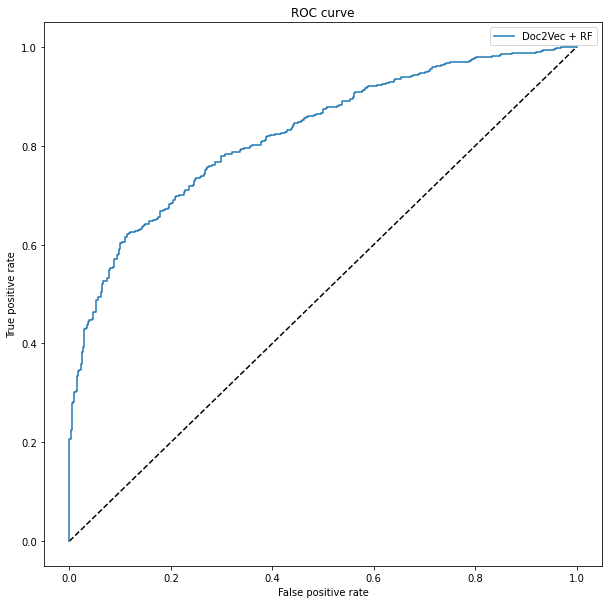

AUC is :0.8235730235154559


<Figure size 720x720 with 0 Axes>

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, preds)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='Doc2Vec + RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
fig1 = plt.gcf()
plt.show()
plt.draw()
#fig1.savefig('doc2vec_rt_roc.png', dpi=100)

print("AUC is :" + str(auc(fpr_rt_lm, tpr_rt_lm)))

<Figure size 720x720 with 0 Axes>

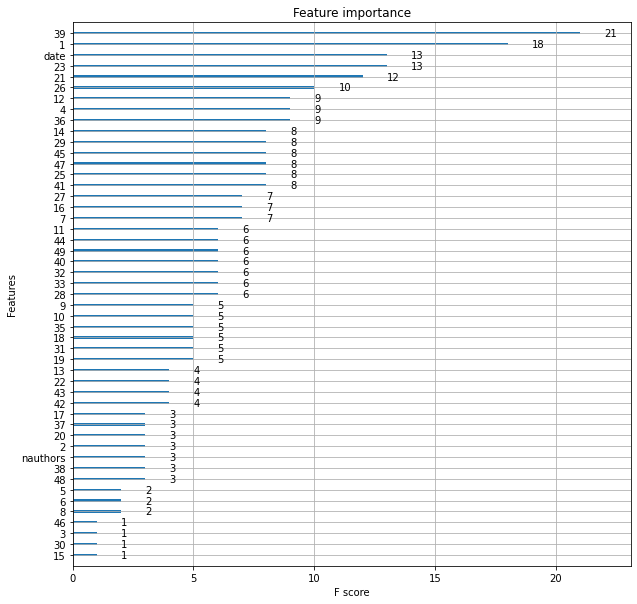

<Figure size 720x720 with 0 Axes>

In [39]:
plt.figure()
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 10]
fig2 = plt.gcf()
plt.show()
plt.draw()
#fig2.savefig('new_data_feature_importance.png', dpi=100)